#model_eval_HAR_stratification.ipynb
Loads the X,y,sub numpy arrays generated by dataset specific get_X_y_sub.ipynb  
Performs stratification twice.
train/test in a 80%/20% split, then 25% of train into validate, so result is 60%/20%/20%  
Builds and evaluates a 1D model.  
Records validation accuracy and test accuracy to log file.

Note:  This is **not** a correct way to separate HAR data; a single subject's data are present in all three groups resulting in higher accuracy than can be expected from a unknown subject.

Tested with X,y,sub arrays generated by load_data_time_series from MobiACT and UniMiB datasets

Author:  Lee B. Hinkle, IMICS Lab, Texas State University, 2021


<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

#Imports

In [2]:
import os
import sys
import shutil #https://docs.python.org/3/library/shutil.html
from shutil import unpack_archive # to unzip
#from shutil import make_archive # to create zip for storage
import requests #for downloading zip file
import glob # to generate lists of files in directory - unix style pathnames
#from scipy import io #for loadmat, matlab conversion
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt # for plotting - pandas uses matplotlib
from tabulate import tabulate # for verbose tables
from keras.utils import to_categorical # for one-hot encoding
import matplotlib.pyplot as plt # for plotting training curves
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GroupKFold
from tensorflow import keras #added to save model
from tensorflow.keras import layers #format matches MNIST example
# to measure and display training time
import time
from datetime import timedelta

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#imports for computing and displaying output metrics
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support


In [3]:
#Helpful functions especially inside colab
from requests import get
def what_is_my_name():
    """returns the name of the running colab ipynb file"""
    #code is readily available on web - not original
    my_name = get('http://172.28.0.2:9000/api/sessions').json()[0]['name']
    return my_name
#start output file with unique name - important for colab runs
def start_logfiles(base_name = "unnamed", first_line = "nothing here"):
    """creates file and writes colab environment info, returns full filename
    which is concatenation of path, base_name, and current UTC time"""
    result_dir = '/content/drive/My Drive/Colab_Run_Results'
    timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) #UTC time
    log_fname = base_name +'_'+timestamp
    full_log_fname = result_dir+'/'+log_fname+'.txt'
    print("Starting text logfile ",full_log_fname)
    with open(full_log_fname, "w") as file_object:
        header = first_line + '\n'
        header += full_log_fname +'\n'
        header += 'Generated by ' + what_is_my_name() + '\n'
        cpu_model = !grep 'model name' /proc/cpuinfo
        header += 'CPU1: ' + cpu_model[0] + '\n'
        header += 'CPU2: ' + cpu_model[1] + '\n'
        gpu_info = !nvidia-smi --query-gpu=gpu_name,driver_version,memory.total --format=csv
        header += 'GPU: ' + str(gpu_info[1]) + '\n'
        file_object.write(header)
    return full_log_fname
#Helper function since frequently checking and logging shapes
#credit https://stackoverflow.com/users/4944093/george-petrov for name method
def namestr(obj, namespace):
    return [name for name in namespace if namespace[name] is obj]
def get_shapes(np_arr_list):
    """Returns text, each line is shape and dtype for numpy array in list
       example: print(get_shapes([X_train, X_test, y_train, y_test]))"""
    shapes = ""
    for i in np_arr_list:
        my_name = namestr(i,globals())
        shapes += (my_name[0] + " shape is " + str(i.shape) \
            + " data type is " + str(i.dtype) + "\n")
    return shapes

#Load the X, y, sub numpy arrays, drop component accel, one-hot encode y


In [4]:
DATASET = "MobiAct"

In [ ]:
DATASET = "UniMiB"

In [5]:
if (DATASET == "MobiAct"):
    input_dir = '/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s'
    ACT = ['JOG','JUM','STD','STN','STU','WAL']
    kernel_size = 20 # kernel is 1 second wide at 20Hz
elif (DATASET == "UniMiB"):
    input_dir = '/content/drive/MyDrive/Processed_Datasets/unimib_xys'
    kernel_size = 50 # kernel is 1 second wide at 50Hz
else:
    print ("Unknown or undefined DATASET")
    sys.exit("Unknown or undefined DATASET")

X = np.load(input_dir + '/' + 'X.npy')
y = np.load(input_dir + '/' +'y.npy')
sub= np.load(input_dir + '/' +'sub.npy')

log_info = 'arrays loaded from'
log_info += input_dir + '\n'
shapes = get_shapes([X,y,sub])
print (log_info,"Starting shape of loaded files")
print(shapes)

# Drop component acceleration
log_info += "Using total component accel, deleting accel_x/y/z from X\n"
X = np.delete(X, [0,1,2],2) # delete columns 1-3 along axis 2
#print(get_shapes([X,y,sub]))

#One-Hot-Encode y...there must be a better way when starting with strings
#https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

if (y.shape[1]==1):
    # integer encode
    y_vector = np.ravel(y) #encoder won't take column vector
    le = LabelEncoder()
    integer_encoded = le.fit_transform(y_vector) #convert from string to int
    name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print("One-hot-encoding: category names -> int -> one-hot")
    print(name_mapping) # seems risky as interim step before one-hot
    log_info += "One Hot:" + str(name_mapping) +"\n\n"
    onehot_encoder = OneHotEncoder(sparse=False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    print("One-hot-encoding",onehot_encoder.categories_)
    y=onehot_encoded
else:
    print ("y.shape[1] is not one, appears to be encoded already. Skipping")

print("\n"+"Final shapes\n"+get_shapes([X,y,sub]))

arrays loaded from/content/drive/My Drive/Processed_Datasets/mobiact_xys/mobiact_xys_20Hz_3s
 Starting shape of loaded files
X shape is (13792, 60, 4) data type is float64
y shape is (13792, 1) data type is <U3
sub shape is (13792, 1) data type is int64

One-hot-encoding: category names -> int -> one-hot
{'JOG': 0, 'JUM': 1, 'STD': 2, 'STN': 3, 'STU': 4, 'WAL': 5}
One-hot-encoding [array([0, 1, 2, 3, 4, 5])]

Final shapes
X shape is (13792, 60, 1) data type is float64
y shape is (13792, 6) data type is float64
sub shape is (13792, 1) data type is int64



#Split arrays into train and test using scikit-learn stratify

In [6]:
#split into train/test using stratify
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
method = "sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)"
new_shapes = (get_shapes([X_train, X_test, y_train, y_test]))
log_info += "Split method " + method + "\n" + new_shapes + "\n"
print ("Split method " + method + "\n" + new_shapes + "\n")
#TODO - without indices cannot verify subject mix
#Add the subjects as a column in X and key off of that?
#https://stackoverflow.com/questions/31521170/scikit-learn-train-test-split-with-indices


Split method sklearn train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)
X_train shape is (11033, 60, 1) data type is float64
X_test shape is (2759, 60, 1) data type is float64
y_train shape is (11033, 6) data type is float64
y_test shape is (2759, 6) data type is float64




#Split training group into train and validation using scikit-learn stratify

In [7]:
#split into train into train and validate
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)
method = "sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)"
new_shapes = (get_shapes([X_train, X_validation, X_test, y_train, y_validation, y_test]))
log_info += "Splitting train into train and validate using \n" + method + "\n" + new_shapes + "\n"
print ("Splitting train into train and validate using \n" + method + "\n" + new_shapes + "\n")

Splitting train into train and validate using 
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
X_train shape is (8274, 60, 1) data type is float64
X_validation shape is (2759, 60, 1) data type is float64
X_test shape is (2759, 60, 1) data type is float64
y_train shape is (8274, 6) data type is float64
y_validation shape is (2759, 6) data type is float64
y_test shape is (2759, 6) data type is float64




# Function: evaluate_model builds and trains Keras 1D CNN model

In [9]:
#different topology and good article here
#https://blog.goodaudience.com/introduction-to-1d-convolutional-neural-networks-in-keras-for-time-sequences-3a7ff801a2cf

def evaluate_model(trainX, trainy, validationX, validationy, 
                    BATCH_SIZE=16, NUM_EPOCHS=200,
                    my_filters = 50, my_kernel_size = 20):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    model = keras.Sequential(
        [
        keras.Input(shape=(n_timesteps,n_features)),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Conv1D(filters=my_filters, kernel_size=my_kernel_size, activation='relu'),
        layers.Dropout(0.5),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.Dense(n_outputs, activation='softmax')
        ]
    )
    #model.summary()
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    history = model.fit(
        trainX,trainy,
        steps_per_epoch=trainX.shape[1]//BATCH_SIZE,
        epochs=NUM_EPOCHS,
        verbose = 0, #0 = silent, 1 = progress bar, 2 = one line per epoch
        validation_data=(validationX,validationy),
        validation_steps=validationX.shape[1]//BATCH_SIZE)
    model.save('my_1D_CNN_model')
    return history

#Function: run_model loads model and predicts using the test dataset

In [10]:
def run_model(testX, testy):
    model = keras.models.load_model('my_1D_CNN_model')
    predictions = model.predict(testX, verbose=0,batch_size=32)
    #must use values not one-hot encoding, use argmax to convert
    y_pred = np.argmax(predictions, axis=-1) # axis=-1 means last axis
    y_test = np.argmax(testy, axis=-1)
    return (accuracy_score(y_test, y_pred)),y_pred, y_test

#Loop train with validation \# repeats times

Starting text logfile  /content/drive/My Drive/Colab_Run_Results/MobiAct_Stratify_Apr-16-2021_2055.txt
--- batch_size = 32 kernel_size = 20 num_epochs = 200

Pass number  1  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:29
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.991


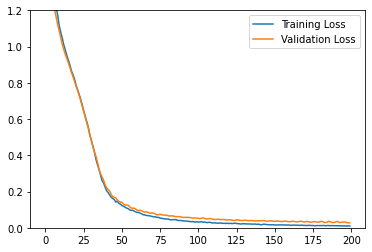

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.994
Pass number  2  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.994


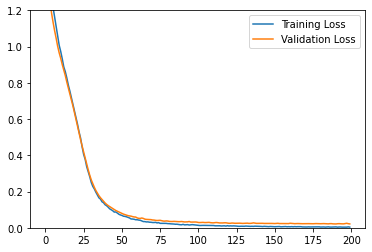

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.996
Pass number  3  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.993


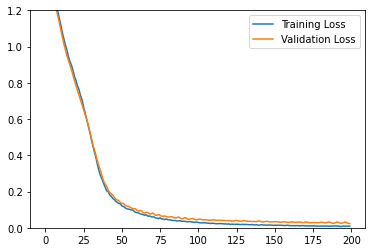

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.995
Pass number  4  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.993


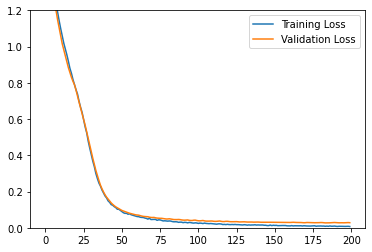

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.994
Pass number  5  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.991


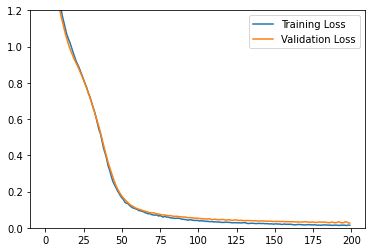

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.992
Pass number  6  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.991


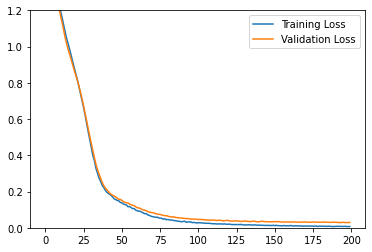

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.993
Pass number  7  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.992


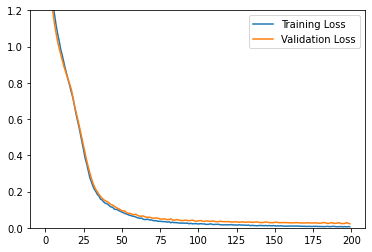

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.992
Pass number  8  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.994


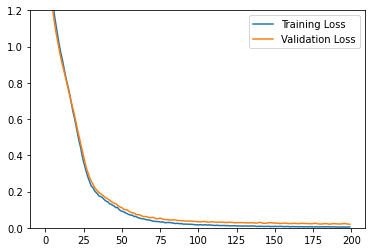

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.994
Pass number  9  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.990


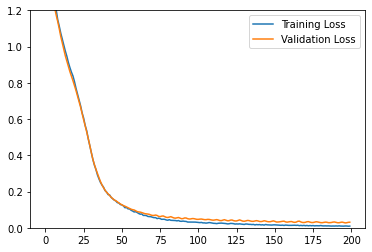

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.991
Pass number  10  of  10
INFO:tensorflow:Assets written to: my_1D_CNN_model/assets
Training time HH:MM:SS =  0:00:10
sklearn train_test_split(X, y, test_size=0.25, random_state=42, stratify=y) 
Validation Accuracy: 0.990


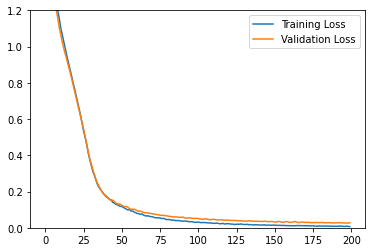

Prediction time HH:MM:SS =  0:00:00
Prediction accuracy: 0.993
Training time,0:00:29,0:00:10,0:00:10,0:00:10,0:00:10,0:00:10,0:00:10,0:00:10,0:00:10,0:00:10
 Validation accuracy,0.991,0.994,0.993,0.993,0.991,0.991,0.992,0.994,0.990,0.990
 Prediction time,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00,0:00:00
 Prediction accuracy,0.994,0.996,0.995,0.994,0.992,0.993,0.992,0.994,0.991,0.993,Avg = ,0.993



In [11]:
#Training Params
BATCH_SIZE = 32
NUM_EPOCHS = 200
#kernel size is set to 1s right after DATABASE is selected
log_full_fname = start_logfiles(base_name=DATASET+'_Stratify',
                                first_line='Stratification' + DATASET)

pass_info = "--- batch_size = " + str(BATCH_SIZE)
pass_info += " kernel_size = " + str(kernel_size)
pass_info += " num_epochs = " + str(NUM_EPOCHS) + "\n"
print (pass_info)
with open(log_full_fname, "a") as file_object:
    file_object.write(log_info)
    file_object.write(pass_info)
repeats = 10;
#for my_split in my_full_list:
for i in range(1):
    for repeat_num in range(repeats):  #rerun current config
        print("Pass number ", repeat_num + 1, " of ",repeats)
        start_time = time.time()
        history = evaluate_model(X_train, y_train, X_validation, y_validation,
                                 BATCH_SIZE, NUM_EPOCHS, my_filters = 50, 
                                 my_kernel_size = kernel_size)
        end_time = time.time()
        training_time = str(timedelta(seconds=(end_time - start_time))).split('.', 2)[0]
        print('Training time HH:MM:SS = ',training_time)
        print(method, "\nValidation Accuracy: %0.3f" % history.history['val_accuracy'][-1])
        #Plot the training and validation loss
        fig = plt.figure()
        plt.plot(history.history["loss"], label="Training Loss")
        plt.plot(history.history["val_loss"], label="Validation Loss")
        plt.legend()
        plt.ylim([0,1.2]) #set limit - 1.2 has been a good value experimentally
        plt.show()
        #Now run trained model against test set
        start_time = time.time()
        #Need to sort this out - returned arrays are re-encoded, but error
        acc = run_model(X_test, y_test)
        end_time = time.time()
        predict_time = str(timedelta(seconds = (end_time - start_time))).split('.', 2)[0]
        print('Prediction time HH:MM:SS = ',predict_time)
        print('Prediction accuracy: {0:.3f}'.format(acc[0]))
        #col_sep = '&' # for import as LaTeX table
        #end_line = '\\\\ \\hline\n' # end of table row with underline for latex
        col_sep = ',' # for csv
        end_line = '\n' # for csv
        if (repeat_num == 0):
            train_time = 'Training time'+ col_sep + training_time
            val_acc = 'Validation accuracy'+ col_sep +'%0.3f' % history.history['val_accuracy'][-1]
            pred_time = 'Prediction time' + col_sep + predict_time
            pred_acc = 'Prediction accuracy' + col_sep + '{0:.3f}'.format(acc[0])
            run_acc = acc[0] #total acc for quick avg calc
        else:
            train_time += col_sep + training_time
            val_acc += col_sep + '%0.3f' % history.history['val_accuracy'][-1]
            pred_time += col_sep + predict_time
            pred_acc += col_sep + '{0:.3f}'.format(acc[0])
            run_acc += acc[0]
    train_time += end_line
    val_acc += end_line
    pred_time += end_line
    pred_acc += col_sep + "Avg = " + col_sep + '{0:.3f}'.format(run_acc/repeats)+ end_line
    print (train_time, val_acc, pred_time, pred_acc)
    with open(log_full_fname, "a") as file_object:
            file_object.write(train_time)
            file_object.write(val_acc)
            file_object.write(pred_time)
            file_object.write(pred_acc)